In [1]:
#package
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import os, json, requests, pickle
import warnings
warnings.filterwarnings('ignore')

# Jakarta Smart City - TransJakarta 🚌

For this capstone project i will be analyzing some TransJakarta call data from [Tableau Public](https://public.tableau.com/vizql/w/Tap-InHalteTransJakartaAgustus2016_0/v/Dashboard2/viewData/sessions/CE382C745645466BBB491DB8B31FA079-0:0/views/10625182665948828489_1461146462161051787?maxrows=200&viz=%7B%22worksheet%22:%22Pengguna%20tiap%20Koridor/jam%22,%22dashboard%22:%22Dashboard%202%22%7D). 
____
In this analysis, some notion of statistics and hypothesis test are used but are very easy to follow. This [handbook of statistics](http://www.biostathandbook.com/index.html) can be used as a reference to explain basics.

____

## Warm up


***Let's first download the dataset and print out the its size***

In [3]:
# Download the TransJakarta - August 2016 dataset
if os.path.exists('TransJkt.csv'): # Check if the dataset is present on local disk and load it
    busway = pd.read_csv('TransJkt.csv',sep = ';')
else: # Download dataset if not available on disk
    url = "https://public.tableau.com/vizql/w/Tap-InHalteTransJakartaAgustus2016_0/v/Dashboard2/viewData/sessions/CE382C745645466BBB491DB8B31FA079-0:0/views/10625182665948828489_1461146462161051787?maxrows=200&viz=%7B%22worksheet%22:%22Pengguna%20tiap%20Koridor/jam%22,%22dashboard%22:%22Dashboard%202%22%7D"
    busway = pd.read_csv(url)
    data.to_csv(url.split('/')[-1])

# Print the size of the dataset
print ("Number of rows / How many records are included in the dataset? :", busway.shape[0])
print ("Number of columns: ", busway.shape[1])

Number of rows / How many records are included in the dataset? : 74457
Number of columns:  11


** Check the head of busway **

In [4]:
busway.head(2)

,Tap-in,Halte,Latitude,Longitude,Count.Pengguna,Hari,Hour,Koridor,Nama Halte,Order,Status
0,53.0,Kota,-6.137.797,106.814.012,106,Friday,0,1,kota,0,depart
1,4.5,Glodok,-6.144.854,106.815.538,9,Friday,0,1,glodok,1,depart


**What is the average passengers ?**

In [5]:
busway['Count.Pengguna'].mean()

333.9102032045342

** Check the info() of the busway **

In [6]:
busway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74457 entries, 0 to 74456
Data columns (total 11 columns):
Tap-in            74457 non-null float64
Halte             74457 non-null object
Latitude          74457 non-null object
Longitude         74457 non-null object
Count.Pengguna    74457 non-null int64
Hari              74457 non-null object
Hour              74457 non-null int64
Koridor           74457 non-null int64
Nama Halte        74457 non-null object
Order             74457 non-null int64
Status            74457 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 6.2+ MB


** What are the top 3 days for TransJakarta? **

In [7]:
busway['Hari'].value_counts().head(3)

Wednesday    10687
Tuesday      10674
Monday       10657
Name: Hari, dtype: int64

** What are the least 3 days for TransJakarta? **

In [6]:
busway['Hari'].value_counts().tail(3)

Thursday    10617
Saturday    10614
Friday      10559
Name: Hari, dtype: int64

** Take a look at the 'Koridor' column, how many bus coridors are there? (coridors) **

In [7]:
busway['Koridor'].nunique()

12

** What is the most busiest coridors for Trans Jakarta based off of this new column? **

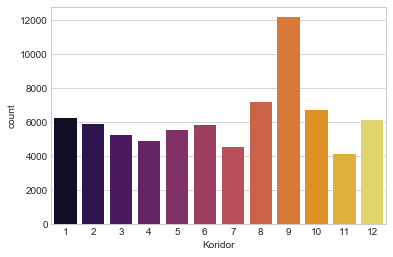

In [47]:
#Koridor 9
sns.countplot(x='Koridor',data=busway,palette='inferno')

** Now i create a groupby object called byHour, where i group the DataFrame by the hour column and use the count() method for aggregation. Using the head() method on this returned DataFrame. **

In [8]:
byHour = busway.groupby('Hour').sum()
byHour.head()

,Tap-in,Count.Pengguna,Koridor,Order
Hour,,,,
0,24150.5,48301,15862,23180
1,14032.5,28065,13893,20458
2,11371.0,22742,12697,18930
3,14044.0,28088,12980,19305
4,32931.0,65862,17886,25689


** Now i create a simple plot off of the dataframe indicating the count of Tap-in per Hour. **

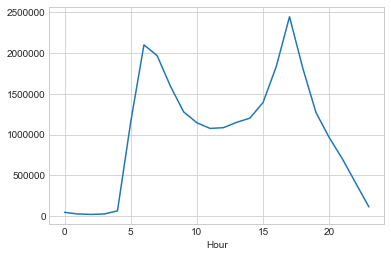

In [9]:
# Could be any column
byHour['Count.Pengguna'].plot()

<Figure size 2160x2160 with 0 Axes>

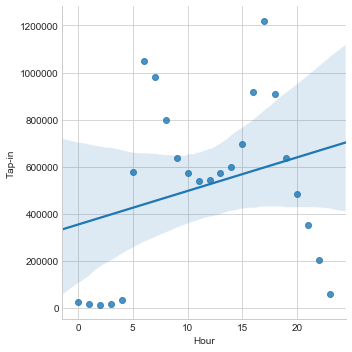

In [51]:
plt.figure(figsize=(30,30))
sns.lmplot(x='Hour',y='Tap-in',data=byHour.reset_index())

** Now i create a gropuby object called byDay, where i group the DataFrame by the day column and use the count() method for aggregation. Using the head() method on this returned DataFrame. **

In [13]:
byDay = busway.groupby('Hari').sum()
byDay.head()

,Tap-in,Count.Pengguna,Hour,Koridor,Order
Hari,,,,,
Friday,1688848.5,3377697,128604,70880,98569
Monday,2192792.5,4385585,129027,71548,99475
Saturday,1311427.0,2622854,129039,71402,99079
Sunday,1281246.0,2562492,128619,71448,99377
Thursday,1707394.5,3414789,128943,71376,99100


** Now i create a simple plot off of the dataframe indicating the count of Tap-in per Day. **

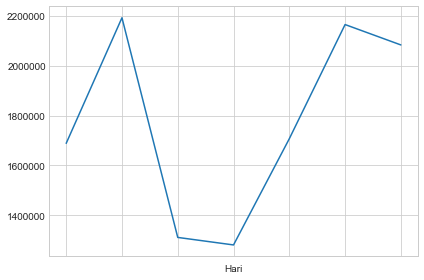

In [14]:
# Could be any column
busway.groupby('Hari').sum()['Tap-in'].plot()
plt.tight_layout()

** Now recreate this plot but i create 1 plot with each plot representing busiest days for the tap-in traffic**

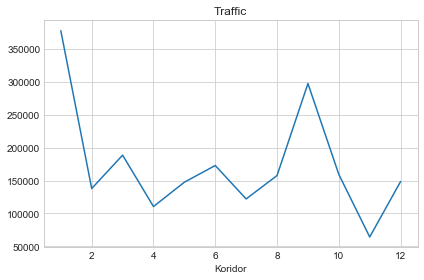

In [15]:
busway[busway['Hari']=='Wednesday'].groupby('Koridor').sum()['Tap-in'].plot()
plt.title('Traffic')
plt.tight_layout()

____
** Now let's move on to creating  heatmaps with seaborn and our busway data. I'll first need to restructure the dataframe so that the columns become the Hours and the Index becomes the Coridors(Koridor). There are lots of ways to do this, but I would recommend trying to combine groupby with an [unstack](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.unstack.html) method. Reference the solutions**

In [64]:
dayCoridor = busway.groupby(by=['Hari','Koridor']).sum()['Tap-in'].unstack()
dayCoridor.head()

Koridor,1,2,3,4,5,6,7,8,9,10,11,12
Hari,,,,,,,,,,,,
Friday,296073.0,105833.0,151030.0,92908.0,114910.0,146741.0,100924.0,128720.5,249876.0,134149.0,53550.0,114134.0
Monday,374023.0,136192.0,199769.0,123181.0,146753.0,188459.5,138016.0,165620.5,324366.0,177827.0,68677.0,149908.5
Saturday,213512.0,89131.0,124427.0,68123.0,104137.0,78087.0,83776.0,102841.0,184444.0,106796.0,44272.0,111881.0
Sunday,252490.0,99583.0,127284.0,63511.0,91674.5,73177.5,81805.0,90691.0,161155.0,93214.0,38464.0,108197.0
Thursday,301500.0,105893.0,151496.0,95256.0,115764.5,149896.0,101401.0,128121.0,252266.0,135666.0,53835.0,116300.0


** Now create a HeatMap using this new DataFrame. **

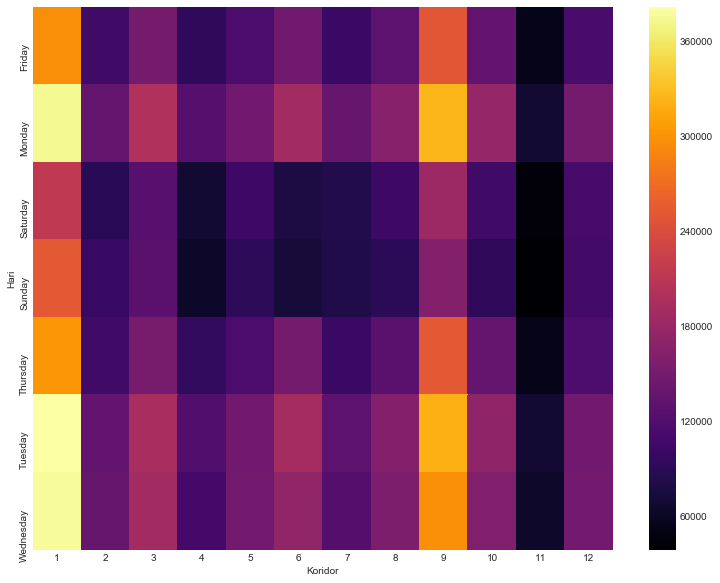

In [65]:
plt.figure(figsize=(13,10))
sns.heatmap(dayCoridor,cmap='inferno')

** Now create a clustermap using this DataFrame. **

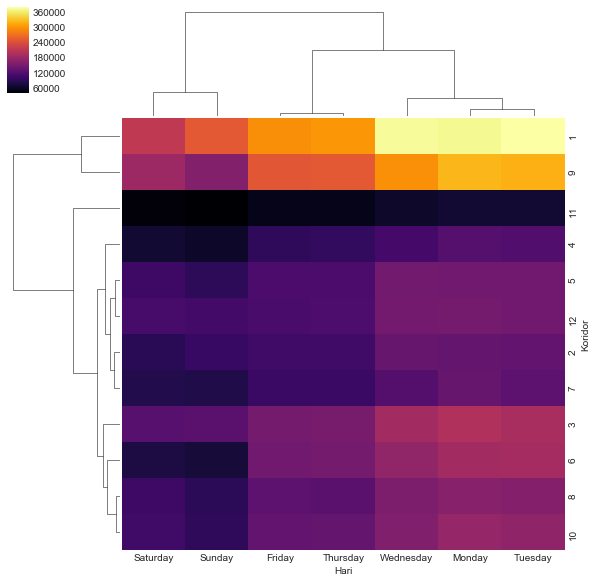

In [63]:
sns.clustermap(dayCoridor,cmap='inferno')

** Now repeat these same plots and operations, for a DataFrame that shows the day as the column. **

In [19]:
dayHour = busway.groupby(by=['Hari','Hour']).sum()['Tap-in'].unstack()
dayHour.head()

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Hari,,,,,,,,,,,,,,,,,,,,,
Friday,2662.5,1395.0,1149.0,1569.0,3612.5,83670.5,158420.0,146697.0,107514.5,77013.5,...,73676.0,87426.5,123319.0,182998.5,131576.0,88623.0,64962.0,52555.5,29992.5,7742.0
Monday,3614.5,2331.5,2286.5,2803.0,7732.5,124139.0,207902.0,190818.0,145868.5,109482.0,...,94778.0,115689.5,160299.5,230707.0,167713.0,110702.5,78939.5,52992.5,28081.5,7730.0
Saturday,3219.5,1592.0,1276.5,1462.5,3079.0,36942.0,68064.0,76336.5,76790.0,72463.5,...,87341.0,89018.5,97126.0,92993.0,79294.5,64530.0,57374.5,48222.5,34244.5,11501.0
Sunday,4680.5,2740.0,2056.5,2054.5,4254.0,34503.5,71267.5,65971.0,80664.0,93889.0,...,79553.5,81166.0,87616.5,80924.5,68575.5,60823.0,50967.5,37655.0,24842.0,6639.0
Thursday,3209.5,1876.5,1305.0,1741.5,4308.5,88267.5,162569.0,150079.5,111605.0,79741.0,...,73217.5,92037.0,128374.5,187319.5,131027.0,88162.5,64409.5,43469.5,23516.5,6203.5


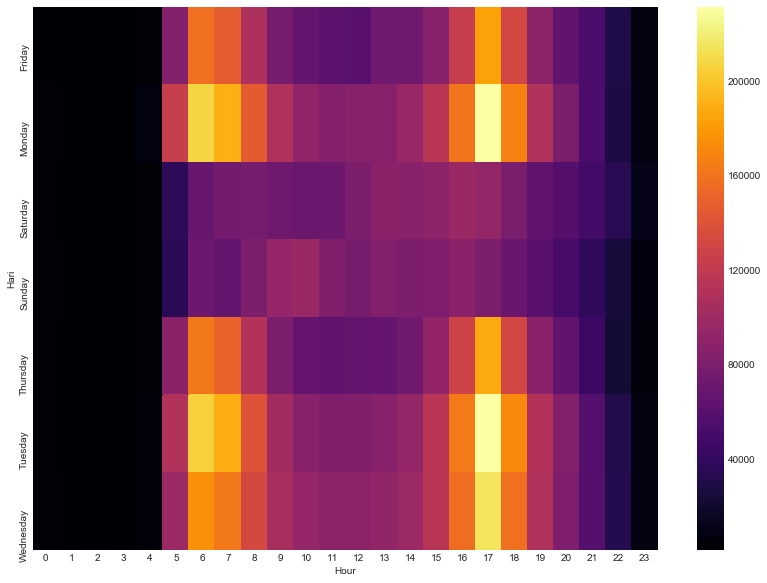

In [66]:
plt.figure(figsize=(14,10))
sns.heatmap(dayHour,cmap='inferno')

<Figure size 1008x720 with 0 Axes>

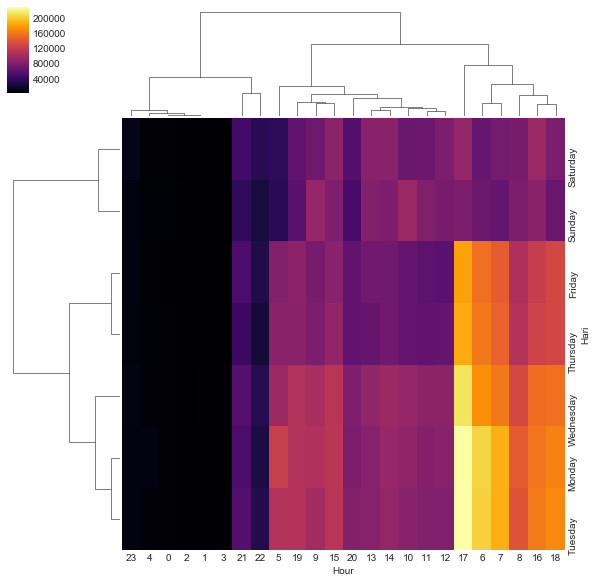

In [44]:
plt.figure(figsize=(14,10))
sns.clustermap(dayHour,cmap='inferno')